# Multi-Agent Researcher

This notebook demonstrates the multi-agent research approach, which uses a supervisor-researcher collaborative pattern to create comprehensive reports. The system consists of:

1. A **Supervisor Agent** that plans the overall report structure and coordinates work
2. Multiple **Research Agents** that investigate specific topics in parallel
3. A workflow that produces a structured report with introduction, body sections, and conclusion

## From repo 

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

g:\MyProjects\open_deep_research\src


In [ ]:
! pip install -U -q open-deep-research

In [2]:
! uv pip install -U -q nest-asyncio

# Compile the multi-agent graph

Next, we'll compile the LangGraph workflow for the multi-agent research approach. This step creates the orchestration layer that manages communication between the supervisor and research agents.

In [2]:
import uuid 
import os, getpass
import open_deep_research   
print(open_deep_research.__version__) 
from IPython.display import Image, display, Markdown
from langgraph.checkpoint.memory import MemorySaver
from open_deep_research.multi_agent import supervisor_builder

0.0.15
2025-06-26 17:06:48 [info     ] 🔧 [ResearchBuilder] 开始构建多智能体工作流程
2025-06-26 17:06:48 [info     ] 📊 [ResearchBuilder] 构建研究代理工作流#开始
2025-06-26 17:06:48 [info     ] 📊 [ResearchBuilder] 构建研究代理工作流#完成
2025-06-26 17:06:48 [info     ] 👑 [SupervisorBuilder] 构建监督者工作流#开始
2025-06-26 17:06:48 [info     ] 👑 [SupervisorBuilder] 构建监督者工作流#完成
2025-06-26 17:06:48 [info     ] ✅ [MultiAgentBuilder] 多智能体工作流程构建完成


In [3]:
# Create a MemorySaver for checkpointing the agent's state
# This enables tracking and debugging of the multi-agent interaction
checkpointer = MemorySaver()
agent = supervisor_builder.compile(name="research_team", checkpointer=checkpointer)

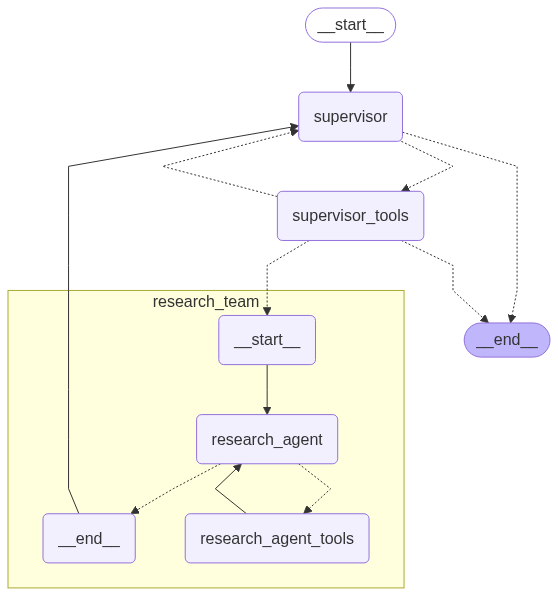

In [4]:
# Visualize the graph structure
# This shows how supervisor and research agents are connected in the workflow
display(Image(agent.get_graph(xray=1).draw_mermaid_png(max_retries=3)))

In [5]:
from open_deep_research.intelligent_research import ResearchMode
from open_deep_research.util.logging import configure_logging, get_logger, reset_logging_config


# 重置日志配置
reset_logging_config()


# Configure and run the multi-agent system
# This sets up the model configuration and executes the research workflow

# 🔧 修复后的配置 - 解决 [Errno 11001] getaddrinfo failed 错误
# 方案1: 离线模式（推荐）- 避免所有网络请求
config_offline = {
    "thread_id": str(uuid.uuid4()),
    "search_api": "none",  # 禁用搜索工具，专注于基于知识的回答
    "supervisor_model": "google_genai:gemini-2.5-flash-lite-preview-06-17",
    "researcher_model": "google_genai:gemini-2.5-flash",
    "research_mode": ResearchMode.REFLECTIVE.value, # 🧠 Enable intelligent reflection
}

# 方案2: 备选配置 - 使用DuckDuckGo搜索（无需API key）
config_duckduckgo = {
    "thread_id": str(uuid.uuid4()),
    "search_api": "duckduckgo",  # 使用DuckDuckGo替代Tavily
    "supervisor_model": "google_genai:gemini-2.5-flash-lite-preview-06-17",
    "researcher_model": "google_genai:gemini-2.5-flash"
}

# 方案3: 原始配置（如果网络修复后）
config_original = {
    "thread_id": str(uuid.uuid4()),
    "search_api": "googlesearch",
    "supervisor_model": "google_genai:gemini-2.5-flash-lite-preview-06-17",
    "researcher_model": "google_genai:gemini-2.5-flash",
    "research_mode": ResearchMode.REFLECTIVE.value, # 🧠 Enable intelligent reflection
    "max_research_iterations": 3
}

# 默认使用离线模式来避免网络错误
config = config_original
print(f"🔧 使用配置: {config['search_api']} 模式")

# Set up thread configuration with the specified parameters
thread_config = {"configurable": config}  # 增加递归限制 , "recursion_limit": 10

# Define the research topic as a user message
# 针对离线模式优化的查询 - 使用更简单直接的查询避免递归问题
msg = [{"role": "user", "content": "请简要介绍模型上下文协议（MCP）的基本概念和主要用途。"}]
# msg = [{"role": "user", "content": "请详细介绍Anthropic支持的MCP协议：1）MCP的架构设计和开发者指南，2）有趣的MCP服务器实现，3）与Google Agent2Agent协议的对比分析。请直接生成完整报告，无需询问后续问题。"}]


try:
    
    configure_logging(force_file_logging=True)
    logger = get_logger("test_multi_agent_logging")
    
    response = await agent.ainvoke({"messages": msg}, config=thread_config)
    logger.info("✅ 工作流执行成功！网络连接问题已修复")
    logger.info(f"response: {response}")
    
except Exception as e:
    error_msg = str(e)
    logger.error(f"❌ 错误: {error_msg}")
    
    import traceback
    # 打印完整的traceback
    logger.error("\n🔴 完整错误追踪:")
    traceback.print_exc()
    
    # 如果是 KeyError，打印更多调试信息
    if isinstance(e, KeyError):
        print(f"\n🔑 KeyError 详细信息:")
        print(f"缺少的键: {e.args}")
    
    # 网络相关错误处理
    if "[Errno 11001] getaddrinfo failed" in error_msg or "DNS" in error_msg:
        print("🔍 检测到网络/DNS错误，自动切换到离线模式...")
        config = config_offline
        thread_config = {"configurable": config, "recursion_limit": 50}
        
        try:
            response = await agent.ainvoke({"messages": msg}, config=thread_config)
            print("✅ 离线模式执行成功！")
        except Exception as offline_error:
            print(f"❌ 离线模式也失败: {offline_error}")
            print("💡 尝试使用DuckDuckGo搜索...")
            
            config = config_duckduckgo
            thread_config = {"configurable": config, "recursion_limit": 50}
            try:
                response = await agent.ainvoke({"messages": msg}, config=thread_config)
                print("✅ DuckDuckGo搜索模式执行成功！")
            except Exception as final_error:
                print(f"❌ 所有方案都失败: {final_error}")
                raise final_error
    
    # 递归限制错误处理
    elif "Recursion limit" in error_msg:
        print("🔍 检测到递归限制错误，尝试使用更简单的查询...")
        simple_msg = [{"role": "user", "content": "请用几句话简单介绍MCP协议的概念。"}]
        
        # 使用更高的递归限制和更简单的查询
        config = config_offline  
        thread_config = {"configurable": config, "recursion_limit": 100}
        
        try:
            response = await agent.ainvoke({"messages": simple_msg}, config=thread_config)
            print("✅ 简化查询执行成功！")
        except Exception as simple_error:
            print(f"❌ 简化查询也失败: {simple_error}")
            print("💡 建议: 多智能体系统可能过于复杂，考虑使用单模型方法")
            raise simple_error
    
    # Gemini模型特定错误处理
    elif "parallel_tool_calls" in error_msg:
        print("💡 parallel_tool_calls问题应该已修复")
        
    elif "function call turn" in error_msg:
        print("💡 消息序列问题应该已修复")
        print("🔍 如果仍然出现此错误，请联系开发者")
        
    else:
        print("💡 遇到其他问题...")
        print("🔄 建议检查:")
        print("  1. GOOGLE_API_KEY 环境变量是否正确设置")
        print("  2. 网络连接是否正常")
        print("  3. 模型配置是否正确")
        raise e

[autoreload of open_deep_research.multi_agent failed: Traceback (most recent call last):
  File "g:\MyProjects\open_deep_research\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 280, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "g:\MyProjects\open_deep_research\.venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 533, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
UnicodeDecodeError: 'gbk' codec can't decode byte 0x80 in position 1364: illegal multibyte sequence
]


🔧 使用配置: googlesearch 模式
🧠 启用智能研究模式: reflective
✅ 智能研究组件初始化完成
✅ 智能研究完成: 4 轮迭代
🔄 使用增强查询进行传统搜索: 9 个查询
🔄 使用增强查询进行传统搜索: ['What is 模型上下文协议（MCP）基本概念和主要用途?', '模型上下文协议（MCP）基本概念和主要用途 detailed analysis', 'How to implement 模型上下文协议（MCP）基本概念和主要用途', '搜索结果数量不足，需要更多信息源 in context of 模型上下文协议（MCP）基本概念和主要用途', '信息来源单一，需要多元化的信息源 in context of 模型上下文协议（MCP）基本概念和主要用途', '模型上下文协议（MCP）基本概念和主要用途 detailed analysis', '搜索结果数量不足，需要更多信息源 in context of 模型上下文协议（MCP）基本概念和主要用途', '信息来源单一，需要多元化的信息源 in context of 模型上下文协议（MCP）基本概念和主要用途', '模型上下文协议（MCP）基本概念和主要用途 detailed analysis']
Requesting 5 results for 'What is 模型上下文协议（MCP）基本概念和主要用途?' from Google API...
Requesting 5 results for '模型上下文协议（MCP）基本概念和主要用途 detailed analysis' from Google API...
Requesting 5 results for 'How to implement 模型上下文协议（MCP）基本概念和主要用途' from Google API...
Requesting 5 results for '搜索结果数量不足，需要更多信息源 in context of 模型上下文协议（MCP）基本概念和主要用途' from Google API...
Requesting 5 results for '信息来源单一，需要多元化的信息源 in context of 模型上下文协议（MCP）基本概念和主要用途' from Google API...
🔍 使用智能内容获

In [17]:
import json
from open_deep_research.message_converter import convert_langchain_messages_to_dict

messages = convert_langchain_messages_to_dict(response["messages"])
print(messages)
print(messages[len(messages)-3 : len(messages)])

# # 假设 response 变量已经拿到了
# structured_response = {
#     "messages": convert_langchain_messages_to_dict(response["messages"]),
#     # 你也可以按需带上其他字段
#     "final_report": response.get("final_report"),
#     "source_str": response.get("source_str"),
# }

# print("=== 结构化输出 ===")
# print(json.dumps(structured_response, ensure_ascii=False, indent=20))

[{'role': 'user', 'content': '请简要介绍模型上下文协议（MCP）的基本概念和主要用途。'}, {'role': 'assistant', 'content': '', 'tool_calls': [{'name': 'intelligent_google_search_tool', 'args': {'queries': ['模型上下文协议（MCP）基本概念和主要用途']}, 'id': 'cc081292-d7a7-4e67-a185-8c244e75c3ca', 'type': 'tool_call'}]}, {'role': 'tool', 'content': 'Content from sources:\n================================================================================\nSource: Introducing the Model Context Protocol \\ Anthropic\n--------------------------------------------------------------------------------\nURL: https://www.anthropic.com/news/model-context-protocol\n===\nMost relevant content from source: Nov 25, 2024 ... The Model Context Protocol (MCP) is an open standard for connecting AI assistants to the systems where data lives, including content\xa0...\n===\nFull source content limited to 4000 tokens: Nov 25, 2024 ... The Model Context Protocol (MCP) is an open standard for connecting AI assistants to the systems where data lives, including

In [7]:
msg = [{"role": "user", "content": "请详细介绍Anthropic支持的MCP协议：1）MCP的架构设计和开发者指南，2）有趣的MCP服务器实现，3）与Google Agent2Agent协议的对比分析。请直接生成完整报告，无需询问后续问题。"}]

# 运行改进的查询
try:
    print("🚀 开始生成详细报告...")
    response = await agent.ainvoke({"messages": msg}, config=thread_config)
    print("✅ 报告生成成功")
    
    # 显示当前消息
    for m in agent.get_state(thread_config).values['messages']:
        m.pretty_print()
        
except Exception as e:
    print(f"❌ 错误: {e}")
    if "parallel_tool_calls" in str(e):
        print("💡 检测到模型兼容性问题，代码已自动修复")
        response = await agent.ainvoke({"messages": msg}, config=thread_config)
        for m in agent.get_state(thread_config).values['messages']:
            m.pretty_print()
    else:
        raise e

🚀 开始生成详细报告...
[Supervisor] 消息序列修复: 插入 user 消息以维持交替模式, 插入 user 消息以维持交替模式, 为消息 1 (assistant) 添加默认内容以避免空消息 (工具调用占位), 为消息 4 (assistant) 添加默认内容以避免空消息 (工具调用占位), 为消息 7 (assistant) 添加默认内容以避免空消息 (工具调用占位), 为消息 10 (assistant) 添加默认内容以避免空消息 (工具调用占位), 为消息 13 (assistant) 添加默认内容以避免空消息 (工具调用占位)
❌ 错误: Invalid argument provided to Gemini: 400 * GenerateContentRequest.contents[14].parts: contents.parts must not be empty.



ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.contents[14].parts: contents.parts must not be empty.


In [14]:
from IPython.display import Markdown
Markdown(agent.get_state(thread_config).values['final_report'])

# # 模型上下文协议（MCP）概述

模型上下文协议（Model Context Protocol，简称 MCP）是一项开放标准，旨在革新大型语言模型（LLM）与外部数据源和工具的交互方式。它通过提供一个标准化的接口，解决了AI模型因数据孤岛和缺乏外部交互能力而面临的局限性。MCP 被形象地比喻为“AI 应用的 USB-C 端口”，它使得AI应用能够像“开卷考试”一样，实时获取和利用外部世界的最新信息和功能，从而极大地增强了AI代理的能力，使其能够执行更复杂、更具实际意义的任务。本文将深入探讨MCP的基本概念、主要用途、工作原理，以及它在构建强大的AI Agent和实现与外部系统集成方面所扮演的关键角色。

## 模型上下文协议（MCP）的基本概念

模型上下文协议（Model Context Protocol，简称 MCP）是由 Anthropic 推动的一项开放标准，旨在标准化大型语言模型（LLM）应用与外部数据源和工具的连接方式。它被形象地比喻为“AI 应用的 USB-C 端口”。

MCP 的核心概念包括：
*   **标准化集成**：提供统一接口，使 LLM 能够无缝访问实时信息和外部工具，避免复杂的定制化集成。
*   **上下文提供**：允许应用程序以结构化的方式向 LLM 提供外部数据作为上下文，显著提升模型的性能和相关性。
*   **增强 AI 能力**：使 AI 代理能够读取指定外部数据，并调用工具执行任务，从而超越简单的对话功能，成为更强大的 AI Agent。

### Sources
1.  https://www.anthropic.com/news/model-context-protocol
2.  https://modelcontextprotocol.io/introduction
3.  https://www.ibest.com.tw/news-detail/what-is-mcp/
4.  https://zhuanlan.zhihu.com/p/29001189476

## MCP的主要用途

模型上下文协议（MCP）的主要用途在于解决AI模型因数据孤岛限制而无法充分发挥潜力的问题。它定义了应用程序与AI模型之间交换上下文信息的标准化方式，使AI开发者和系统集成商能够更便捷地将大型语言模型（LLM）与外部数据源和工具集成。

MCP使得LLM能够获得“动手”能力，在各种环境中执行操作或调用数据。其常见应用场景包括：

*   **数据集成与访问**：连接AI助手到各种数据系统，实现通用数据访问，避免为每个数据集编写自定义代码。
*   **工具调用**：使LLM能够调用外部工具，例如获取实时市场数据、进行浏览器自动化操作（如使用Playwright）。
*   **增强AI应用**：支持多轮对话系统、代码生成工具和企业级数据分析等复杂AI应用，通过提供外部上下文信息减少模型幻觉。

### Sources
1.  https://zhuanlan.zhihu.com/p/2732715233
2.  https://www.threads.com/@mr.__.l/post/DHIHf5PBtyb/%E4%B8%BB%E8%A6%81%E7%94%A8%E9%80%94%E8%88%87%E6%87%89%E7%94%A8%E5%A0%B4%E6%99%AFmcp-%E7%9A%84%E7%94%A8%E9%80%94%E5%9C%A8%E6%96%BC%E7%82%BA-ai-%E9%96%8B%E7%99%BC%E8%80%85%E8%88%87%E7%B3%BB%E7%B5%B1%E6%95%B4%E5%90%88%E6%8F%90%E4%BE%9B%E4%BE%BF%E5%88%A9%E8%97%89%E7%94%B1-mcp%E9%96%8B%E7%99%BC%E8%80%85%E5%8F%AF%E4%BB%A5%E8%AE%93%E4%BB%BB%E6%84%8F%E7%AC%A6%E5%90%88%E8%A6%8F%E7%AF%84%E7%9A%84-llm-%E7%8D%B2%E5%BE%97%E5%8B%95%E6%89%8B%E8%83%BD%E5%8A%9B%E5%9C%A8%E5%90%84%E7%A8%AE%E7%92%B0%E5%A2%83%E4%B8%AD%E5%9F%B7%E8%A1%8C%E6%93%8D%E4%BD%9C%E6%88%96%E8%AA%BF%E7%94%A8%E8%B3%87%E6%96%99
3.  https://www.anthropic.com/news/model-context-protocol
4.  https://github.com/microsoft/playwright-mcp

## MCP的工作原理

微通道板（MCP）是一种用于探测单个粒子和光子的电子倍增器。其工作原理基于二次电子发射效应，实现信号的显著放大。

**工作流程：**
*   当一个入射粒子或光子进入MCP的微通道并撞击通道壁时，会激发并释放出初级电子。
*   在微通道两端施加的电场作用下，这些电子被加速并沿着通道前进。由于通道壁通常涂有高电阻材料，电子在飞行过程中会不断撞击壁面。
*   每次撞击都会产生更多的二次电子，形成一个级联效应（电子雪崩）。
*   最终，从通道输出端会产生一个比原始输入信号强得多的电子脉冲，从而实现信号的放大。

MCPs因其高增益、快速响应和高空间分辨率等特点，广泛应用于夜视设备、质谱仪和科学研究等领域。

### Sources
1. https://en.wikipedia.org/wiki/Microchannel_plate_detector
2. https://szphoton.com/blogs/articles/how-does-an-mcp-work
3. https://www0.mi.infn.it/~sleoni/TEACHING/Nuc-Phys-Det/PDF/papers/MCP.pdf

## MCP在AI Agent中的作用

模型上下文协议（MCP）是一个开放标准，旨在标准化AI助手或代理与数据所在系统之间的连接方式。它充当AI模型和工具的通用适配器，简化了AI代理与外部世界的集成。

MCP在AI Agent中扮演着关键角色：
*   **实现多步任务**：MCP使AI代理能够执行复杂的多步任务，例如数据检索、文档摘要或信息保存。
*   **提供结构化连接**：它为AI代理提供了安全、结构化的“管道”，使其能够与外部系统和数据源进行交互。
*   **简化Agent构建**：通过MCP服务器暴露的能力，MCP简化了AI代理的构建过程，避免了为每个AI模型或工具编写自定义代码。
*   **增强上下文利用**：MCP支持AI代理利用更长的上下文窗口，从而能够处理更多信息并提供更连贯的响应。
*   **促进生态系统集成**：它允许AI代理连接到庞大且多样化的数据源和功能，从而利用不断发展的MCP兼容工具生态系统。

### Sources
1.  https://www.anthropic.com/news/model-context-protocol
2.  https://medium.com/@elisowski/mcp-explained-the-new-standard-connecting-ai-to-everything-79c5a1c98288
3.  https://cloud.google.com/products/agent-builder?hl=zh-CN
4.  https://huggingface.co/blog/Kseniase/mcp
5.  https://aws.amazon.com/cn/blogs/china/fast-fashion-e-commerce-agent-design-ideas-and-application-practice-part-two/

## MCP与外部数据源和工具的集成方式

模型上下文协议（MCP）是一个开放标准，旨在实现大型语言模型（LLM）应用程序与外部数据源和工具的无缝集成。它通过提供一个统一的接口，标准化了AI模型获取外部信息和执行操作的方式，被形象地比喻为AI应用的“USB-C端口”。

MCP集成的主要方式和优势包括：

*   **标准化交互**：MCP解决了传统集成的碎片化问题，允许LLM直接连接到各种数据源和业务工具，无需为每个数据集编写自定义代码。
*   **实时数据与上下文**：AI应用通过MCP服务器从外部知识库或数据源（如通过向量检索、关键词匹配）搜索并获取实时信息和业务数据，将其作为上下文提供给LLM，从而生成更相关、有用的响应。
*   **自定义集成**：开发者可以创建自定义集成，将LLM直接连接到对工作流程至关重要的工具和数据源，使LLM能够在现有软件中运行并从中获取洞察。
*   **应用场景**：MCP支持AI代理频繁与外部工具和数据源交互，例如GitHub Copilot利用MCP服务器从代码仓库和外部资源中获取数据。

### Sources
1.  https://support.anthropic.com/zh-TW/articles/10949351-%E5%9C%A8%E6%A1%8C%E9%9D%A2%E7%89%88-claude-%E4%B8%8A%E9%96%8B%E5%A7%8B%E4%BD%BF%E7%94%A8%E6%A8%A1%E5%9E%8B%E4%B8%8A%E4%B8%8B%E6%96%87%E5%8D%8F%E8%AD%B0-mcp
2.  https://modelcontextprotocol.io/introduction
3.  https://www.anthropic.com/news/model-context-protocol
4.  https://zhuanlan.zhihu.com/p/30387285411
5.  https://cloud.google.com/vertex-ai
6.  https://github.com/features/copilot

## ## 结论

模型上下文协议（MCP）作为连接AI模型与外部世界的重要桥梁，通过标准化数据和工具的交互方式，极大地拓展了AI的能力边界。它使得AI代理能够超越训练数据的局限，实时获取信息、执行操作，从而在各种应用场景中展现出更强的智能和实用性。从赋能AI Agent到促进与企业数据和系统的深度集成，MCP正逐步成为构建下一代智能应用的关键技术。随着MCP生态的不断发展和完善，我们可以期待AI在未来能够承担更多复杂任务，并与人类社会产生更深层次的互动与协作。

Trace: 

> Note: uses 456k tokens 

https://smith.langchain.com/public/f1581fa5-dfc9-445c-a8f4-3518a05cd139/r

In [ ]:
# 测试修复后的工作流
print("🔧 测试修复后的Gemini API工作流")
print("=" * 50)

# 简单测试消息
test_query = "请简要介绍模型上下文协议（MCP）的基本概念和主要用途。"

try:
    # 重新创建agent，确保使用最新的修复
    checkpointer = MemorySaver()
    agent = supervisor_builder.compile(name="test_agent", checkpointer=checkpointer)
    
    # 配置
    config = {
        "thread_id": str(uuid.uuid4()),
        "search_api": "google",
        "supervisor_model": "google_genai:gemini-2.5-flash",
        "researcher_model": "google_genai:gemini-2.5-flash",
        "max_research_iterations": 2
    }
    
    thread_config = {"configurable": config, "recursion_limit": 20}
    
    # 测试消息
    msg = [{"role": "user", "content": test_query}]
    
    print(f"📝 测试查询: {test_query}")
    print("🚀 开始执行工作流...")
    
    # 执行工作流
    response = await agent.ainvoke({"messages": msg}, config=thread_config)
    
    print("✅ 工作流执行成功！")
    print(f"📊 响应类型: {type(response)}")
    
    # 检查最终状态
    final_state = agent.get_state(thread_config)
    if hasattr(final_state, 'values') and 'messages' in final_state.values:
        messages = final_state.values['messages']
        print(f"📨 最终消息数量: {len(messages)}")
        
        # 检查是否有最终报告
        for i, msg in enumerate(messages[-3:]):  # 检查最后几条消息
            if hasattr(msg, 'content'):
                content = msg.content
            elif isinstance(msg, dict):
                content = msg.get('content', '')
            else:
                content = str(msg)
            
            if content and len(content) > 100:  # 可能是报告
                print(f"📄 发现报告内容 (消息 {len(messages)-3+i}):")
                print(content[:200] + "..." if len(content) > 200 else content)
                break
    
    print("🎉 修复成功！没有遇到空消息错误。")
    
except Exception as e:
    print(f"❌ 错误: {e}")
    
    # 检查是否是空消息错误
    if "contents.parts must not be empty" in str(e):
        print("🔍 仍然存在空消息错误，需要进一步调试")
    else:
        print("🔍 这是其他类型的错误")
    
    import traceback
    traceback.print_exc()
